In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchsummary import summary


import soundfile as sf

In [2]:
class AudioDataset(Dataset):
    def __init__(self, path, train=True, transform=None, sample_rate=16000):
        self.path = path
        if train:
            self.normal_data_path = os.path.join(path, 'train/normal')
            self.abnormal_data_path = os.path.join(path, 'train/abnormal')
        else:
            self.normal_data_path = os.path.join(path, 'test/normal')
            self.abnormal_data_path = os.path.join(path, 'test/abnormal')
        
        self.normal_data_list = glob.glob(os.path.join(self.normal_data_path, '*.wav'))
        self.abnormal_data_list = glob.glob(os.path.join(self.abnormal_data_path, '*.wav'))
        self.data_list = self.normal_data_list + self.abnormal_data_list
        self.label_list = [0]*len(self.normal_data_list) + [1]*len(self.abnormal_data_list)
        
        self.transform = transform
        self.sr = sample_rate
        self.frame_length = 0.025
        self.frame_stride = 0.0126

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data_path = self.data_list[idx]
        label = self.label_list[idx]
        data = self.log_Mel_S(data_path)
        data = np.expand_dims(data, axis=0)

        if self.transform is not None:
            data = self.transform(data)
        return data, label # (1, 40, 80)
    
    def log_Mel_S(self, wav_file):
        y, sr = librosa.load(wav_file, sr=self.sr)
        if len(y) < 16000:
            y = np.pad(y, (0,16000 - len(y)))
        elif len(y) > 16000:
            y = y[:16000]
        else:
            y = y

        input_nfft = int(round(sr * self.frame_length))
        input_stride = int(round(sr * self.frame_stride))

        s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
        s = librosa.power_to_db(s, ref=np.max)
        return s

In [3]:
dataset = AudioDataset(path='/mnt/storage1/위급상황 음성_음향/Training/bc_data', train=True)

print(f'dataset.__len__() : {dataset.__len__()}')
dataset_indices = list(range(dataset.__len__()))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset.__len__()))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=dataset, batch_size=100, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(dataset=dataset, batch_size=100, sampler=val_sampler, shuffle=False)

dataset.__len__() : 45386


In [4]:
class BC(nn.Module):
    def __init__(self, input_channel=1):
        super(BC, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 5 * 10, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out

In [5]:
bc = BC()
if torch.cuda.is_available():
    bc.cuda()

In [6]:
bc

BC(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6400, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=T

In [7]:
summary(bc, (1, 40, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 80]             320
       BatchNorm2d-2           [-1, 32, 40, 80]              64
              ReLU-3           [-1, 32, 40, 80]               0
         MaxPool2d-4           [-1, 32, 20, 40]               0
            Conv2d-5           [-1, 64, 20, 40]          18,496
       BatchNorm2d-6           [-1, 64, 20, 40]             128
              ReLU-7           [-1, 64, 20, 40]               0
         MaxPool2d-8           [-1, 64, 10, 20]               0
            Conv2d-9          [-1, 128, 10, 20]          73,856
      BatchNorm2d-10          [-1, 128, 10, 20]             256
             ReLU-11          [-1, 128, 10, 20]               0
        MaxPool2d-12           [-1, 128, 5, 10]               0
          Flatten-13                 [-1, 6400]               0
           Linear-14                  [

In [8]:
def train(model, loss, optimizer, num_epochs, start_epoch=0, early_stopping=False):
    train_loss_arr = []
    train_acc_arr = []
    test_loss_arr = []
    test_acc_arr = []
    
    best_test_loss = 999999
    early_stop, early_stop_max = 0, 3

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0.
        epoch_acc = 0.
        for batch_idx, data in enumerate(train_loader):
            train_x, train_y = data[0].cuda(), data[1].cuda()
            optimizer.zero_grad()

            model.train()
            outputs = model(train_x)
            y_pred = torch.round(outputs)
            batch_acc = ( (y_pred == train_y.unsqueeze(1)).sum() / train_y.shape[0] ) * 100
            epoch_acc += batch_acc.item()

            train_loss = loss(outputs.float(), train_y.unsqueeze(1).float())
            epoch_loss += train_loss.item()

            train_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch : {epoch + 1} [{batch_idx * len(train_x)}/{len(train_idx)}({100 * 100. * batch_idx/len(train_idx) :.2f}%)]'\
                    +f'\tLoss : {train_loss.item() / len(train_x) :.4f}, Accuracy : {batch_acc}%')
        
        train_acc_arr.append((epoch_acc / len(train_idx)))
        train_loss_arr.append((epoch_loss / len(train_idx)))

        # validation

        model.eval()
        test_loss = 0.
        test_acc = 0.
        for test_x, test_y in val_loader:
            test_x = test_x.cuda()
            test_y = test_y.cuda()

            outputs = model(test_x)
            y_pred = torch.round(outputs)
            acc = ( (y_pred == test_y.unsqueeze(1)).sum() / test_y.shape[0] ) * 100
            test_acc += acc.item()

            batch_loss = loss(outputs.float(), test_y.unsqueeze(1).float())
            test_loss += batch_loss.item()

        test_acc_arr.append((test_acc / len(val_idx)))
        test_loss_arr.append((test_loss / len(val_idx)))

        if early_stopping:
            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
                print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}, Average Train Accuracy : {train_acc_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Accuracy : {test_acc_arr[epoch-start_epoch] :.4f}\n')
            else:
                early_stop += 1
                print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}, Average Train Accuracy : {train_acc_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Accuracy : {test_acc_arr[epoch-start_epoch] :.4f}\n')

            if early_stop >= early_stop_max:
                break
        else:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
            f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}, Average Train Accuracy : {train_acc_arr[epoch-start_epoch] :.4f}, ' +\
            f'Average Test Accuracy : {test_acc_arr[epoch-start_epoch] :.4f}\n')
    return train_acc_arr, train_loss_arr, test_acc_arr, test_loss_arr

In [9]:
bc_loss = nn.BCELoss()
bc_optimizer = optim.Adam(bc.parameters())
avg_train_acc, avg_train_loss, avg_test_acc, avg_test_loss = train(bc, bc_loss, bc_optimizer, 50, start_epoch=0, early_stopping=True)

Epoch : 1 [0/36309(0.00%)]	Loss : 0.0078, Accuracy : 29.0%
Epoch : 1 [1000/36309(2.75%)]	Loss : 0.0009, Accuracy : 97.0%
Epoch : 1 [2000/36309(5.51%)]	Loss : 0.0005, Accuracy : 98.99999237060547%
Epoch : 1 [3000/36309(8.26%)]	Loss : 0.0001, Accuracy : 100.0%
Epoch : 1 [4000/36309(11.02%)]	Loss : 0.0003, Accuracy : 97.99999237060547%
Epoch : 1 [5000/36309(13.77%)]	Loss : 0.0002, Accuracy : 100.0%
Epoch : 1 [6000/36309(16.52%)]	Loss : 0.0007, Accuracy : 98.99999237060547%
Epoch : 1 [7000/36309(19.28%)]	Loss : 0.0001, Accuracy : 98.99999237060547%
Epoch : 1 [8000/36309(22.03%)]	Loss : 0.0000, Accuracy : 100.0%
Epoch : 1 [9000/36309(24.79%)]	Loss : 0.0003, Accuracy : 98.99999237060547%
Epoch : 1 [10000/36309(27.54%)]	Loss : 0.0000, Accuracy : 100.0%
Epoch : 1 [11000/36309(30.30%)]	Loss : 0.0002, Accuracy : 100.0%
Epoch : 1 [12000/36309(33.05%)]	Loss : 0.0001, Accuracy : 100.0%
Epoch : 1 [13000/36309(35.80%)]	Loss : 0.0000, Accuracy : 100.0%
Epoch : 1 [14000/36309(38.56%)]	Loss : 0.0000, Ac

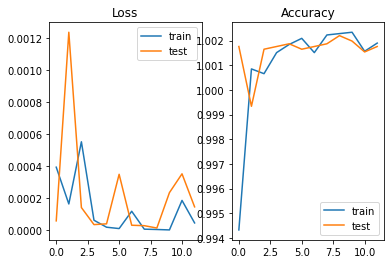

In [10]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(avg_train_loss, label='train')
plt.plot(avg_test_loss, label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(avg_train_acc, label='train')
plt.plot(avg_test_acc, label='test')
plt.legend()

plt.show()

In [12]:
torch.save(bc.state_dict(), 'model/bc_0404.pt')

In [13]:
def log_Mel_S(wav_file):
    sr = 16000
    frame_length = 0.025
    frame_stride = 0.0126 
    y, sr = librosa.load(wav_file, sr=sr)
    if len(y) < 16000:
        y = np.pad(y, (0,16000 - len(y)))
    elif len(y) > 16000:
        y = y[:16000]
    else:
        y = y

    input_nfft = int(round(sr * frame_length))
    input_stride = int(round(sr * frame_stride))

    s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    s = librosa.power_to_db(s, ref=np.max)
    return s


In [19]:
bc.eval()
data_path = 'data/원천데이터/abnormal_1s/가스사고_512992_label_1.wav'
s = log_Mel_S(data_path)
out = bc(torch.Tensor(s.reshape(1,1,40,80)).cuda())
out

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
data_path = 'data/원천데이터/normal_1s/실내_673584_label_0.wav'
s = log_Mel_S(data_path)
out = bc(torch.Tensor(s.reshape(1,1,40,80)).cuda())
out

tensor([[2.6489e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
data_list = glob.glob('/mnt/storage1/위급상황 음성_음향/Training/abnormal_1s_high/*.wav')
abnormal_pred_list = []
for i in data_list:
    s = log_Mel_S(i)
    out = bc(torch.Tensor(s.reshape(1,1,40,80)).cuda())
    pred = torch.round(out).item()
    abnormal_pred_list.append(pred)

In [22]:
(np.array(abnormal_pred_list) == 0).sum()

15

In [23]:
data_list = glob.glob('/mnt/storage1/위급상황 음성_음향/Training/low_16_1s/*.wav')
normal_pred_list = []
for i in data_list:
    s = log_Mel_S(i)
    out = bc(torch.Tensor(s.reshape(1,1,40,80)).cuda())
    pred = torch.round(out).item()
    normal_pred_list.append(pred)

In [24]:
(np.array(normal_pred_list) == 1).sum()

5

In [26]:
TN = (np.array(abnormal_pred_list) == 1).sum()
FP = (np.array(abnormal_pred_list) == 0).sum()
TP = (np.array(normal_pred_list) == 0).sum()
FN = (np.array(normal_pred_list) == 1).sum()

print(f"{' '*15}Predict{' '*15}")
print(f"{' '*13}{'Normal':10s}{'Abnormal':10s}")
print(f"Normal  {TP:10d}{FN:11d}")
print(f"Abnormal{FP:10d}{TN:11d}")

               Predict               
             Normal    Abnormal  
Normal       23858          5
Abnormal        15      32853
